# Running Times on Benchmark Graphs

This is a weak scaling experiment.
We start with one node and a graph with 16M nodes. 
Then we double both in each step.
The amount of work per node should stay constant.
10 runs per configuration were performed.
We used an External Memory LFR generator to generate the graphs.

In [1]:
import numpy as np
import matplotlib as mpl
%matplotlib inline

import pandas as pd

import json
import glob
import os

In [2]:
def plot_and_save(df, name, kind='line', xlabel=None, ylabel=None, **kwargs):
    ax = df.plot(kind=kind, **kwargs)
    
    if xlabel != None:
        ax.set_xlabel(xlabel)
    if ylabel != None:
        ax.set_ylabel(ylabel)
    
    df.to_csv("../../paper/plots/" + name + ".csv")
    if 'yerr' in kwargs:
        kwargs['yerr'].to_csv("../../paper/plots/" + name + "_std_err.csv")

In [3]:
data = {}

for path in glob.glob("../../data/results/weak_scaling/*.json"):
  for typename, items in json.load(open(path)).items():
      if typename in data:
        for key, object_data in items.items():
          if key in data[typename]:
            data[typename][key].update(object_data)
          else:
            data[typename][key] = object_data
      else:
        data[typename] = items

frames = { typename: pd.DataFrame.from_dict(items, orient='index') for typename, items in data.items() }

In [4]:
dlslm_label = 'DSLM-Mod'
dlslm_me_label = 'DSLM-Map'
seq_postfix = ' w. Seq.'
no_contraction_postfix = ' w/o Cont.'
dlslm_ws_label = dlslm_label + seq_postfix
dlslm_nc_label = dlslm_label + no_contraction_postfix

algo_name_mapping = {
    'synchronous local moving with map equation': dlslm_me_label,
    'synchronous local moving with modularity': dlslm_label
}

frames['algorithm_run'].replace({ 'algorithm': algo_name_mapping }, inplace=True)

frames['algorithm_run']['algorithm'] += frames['algorithm_run'].merge(frames['program_run'], left_on='program_run_id', right_index=True, how='left')['switch_to_seq'].map({ False: '', True: seq_postfix, np.NaN: '' })
frames['algorithm_run']['algorithm'] += frames['algorithm_run'].merge(frames['program_run'], left_on='program_run_id', right_index=True, how='left')['contraction'].map({ False: no_contraction_postfix, True: '', np.NaN: '' })

In [5]:
frames['algorithm_run']['runtime'] = (frames['algorithm_run']['done_ts'] - frames['algorithm_run']['start_ts']) / 1000000.0
if 'distributed_algorithm_run_id' in frames['algorithm_run']:
    distributed_algo_runs = frames['algorithm_run'][pd.isnull(frames['algorithm_run'].distributed_algorithm_run_id)]
else:
    distributed_algo_runs = frames['algorithm_run']

## Average running times and standard deviation for each configuration

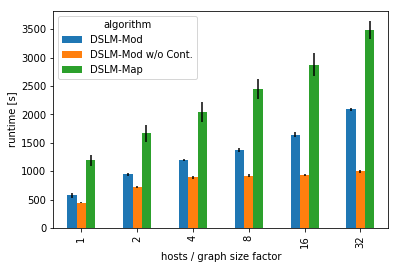

In [6]:
df = distributed_algo_runs \
    .merge(frames['program_run'], left_on='program_run_id', right_index=True) \
    .groupby(['hosts', 'algorithm'])['runtime'].mean().to_frame().unstack() \
    ["runtime"][[dlslm_label, dlslm_nc_label, dlslm_me_label]]
    
df_errors = distributed_algo_runs \
    .merge(frames['program_run'], left_on='program_run_id', right_index=True) \
    .groupby(['hosts', 'algorithm'])['runtime'].std().to_frame().unstack() \
    ["runtime"][[dlslm_label, dlslm_nc_label, dlslm_me_label]]

plot_and_save(df, "weak_scaling_runtime", yerr=df_errors, kind='bar', ylabel="runtime [s]", xlabel="hosts / graph size factor")